# Progression of selfplay games
Using the conservative strategy (move count of first dead line)
* Games 0 to 100: Fixed move order
* Games 100 to 200: `20190809/0_100_epox69_clr1.0_e66`
* Games 200 to 300: `20190809/0_200_epox64_clr0.003_e62`
* Games 300 to 400: `20190811/0_300_epox38_clr0.009_e36`
* Games 400 to 500: `20190812/0_400_epox22_clr0.038_e20`
* Gamse 500 to 600: `20190813/0_500_epox30_clr0.01_e28`

In [1]:
import os
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
os.chdir('selfplay/min_move_dead/')

In [2]:
indices = []
moves = []
scores = []
tiles = []
i = 0
while True:
    try:
        x = np.load('min'+str(i).zfill(5)+'.npz')
        indices.append(i)
        moves.append(len(x['moves']))
        scores.append(x['score'])
        tiles.append(np.amax(x['boards'][-1]))
        i += 1
    except FileNotFoundError:
        print('Got {} games'.format(i))
        break

Got 600 games


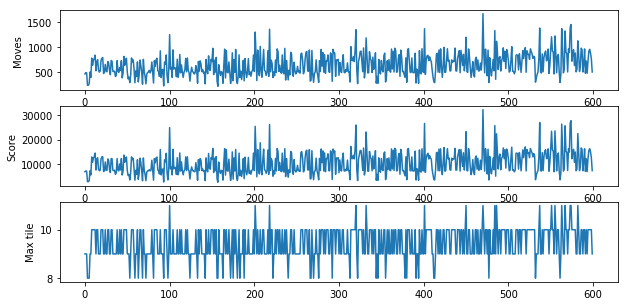

In [3]:
plt.subplots(figsize=(10, 5))
plt.subplot(311)
plt.plot(indices, moves)
plt.ylabel('Moves')
plt.subplot(312)
plt.plot(indices, scores)
plt.ylabel('Score')
plt.subplot(313)
plt.plot(indices, tiles)
plt.ylabel('Max tile')
plt.show()

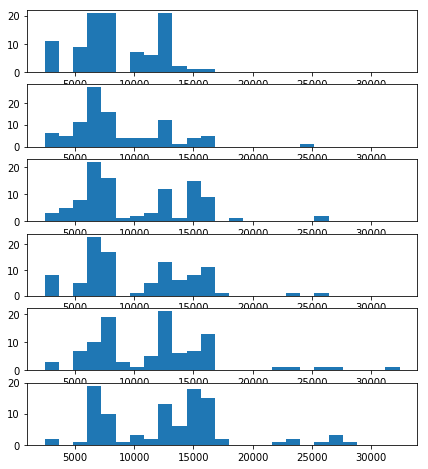

In [4]:
blocks = len(scores) // 100
xlim = (min(scores), max(scores))
plt.subplots(figsize=(7, 8))
for i in range(blocks):
    plt.subplot(blocks, 1, i+1)
    plt.hist(scores[100*i:100*(i+1)], range=xlim, bins=25)
plt.show()

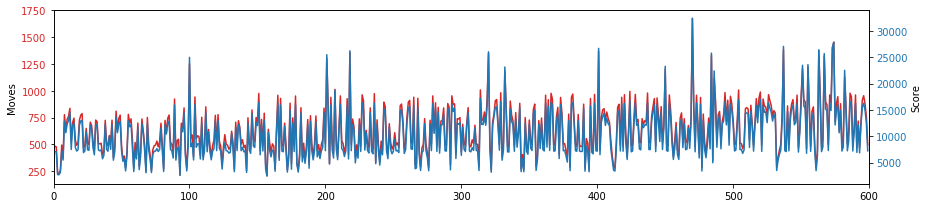

In [5]:
fig, ax1 = plt.subplots(figsize=(13,3))

color = 'tab:red'
ax1.plot(indices, moves, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('Moves')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.plot(indices, scores, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('Score')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.xlim([0, max(indices)+1])
plt.show()

In [6]:
# Test if variances are the same
for i in range(blocks-1):
    print(stats.bartlett(moves[100*i:100*(i+1)], moves[100*(i+1):100*(i+2)]))

BartlettResult(statistic=1.9953532964872964, pvalue=0.15778226888725355)
BartlettResult(statistic=2.8908309749493304, pvalue=0.0890849663533444)
BartlettResult(statistic=0.008791231986020219, pvalue=0.9252985599459512)
BartlettResult(statistic=0.4184523695090759, pvalue=0.5177102936455499)
BartlettResult(statistic=0.2006762498970433, pvalue=0.6541755494287144)


In [9]:
# Test if means are the same
for i in range(blocks-1):
    print(stats.ttest_ind(moves[100*i:100*(i+1)], moves[100*(i+1):100*(i+2)], equal_var=False))

Ttest_indResult(statistic=-0.3759025995137922, pvalue=0.7073998097584937)
Ttest_indResult(statistic=-2.549881698109302, pvalue=0.01155486971339739)
Ttest_indResult(statistic=-0.13206640517518659, pvalue=0.8950658864250953)
Ttest_indResult(statistic=-1.8919239871700335, pvalue=0.05996678485722376)
Ttest_indResult(statistic=-1.8213691554709392, pvalue=0.07006299481017128)


In [15]:
tmp = np.vstack([np.mean(np.reshape(moves, (blocks, 100)), axis=1),
                 np. std(np.reshape(moves, (blocks, 100)), axis=1)])
print(np.round(tmp, 0))

[[549. 558. 634. 638. 700. 763.]
 [165. 190. 225. 223. 238. 249.]]


Higher scoring games. Variance increases.

# Move distribution

In [16]:
moves = []
step = 100
for i in range(0, len(indices)-len(indices)%step, step):
    m = []
    for j in range(i, i+step):
        x = np.load('min'+str(j).zfill(5)+'.npz')
        m.extend(x['moves'])
    moves.append(m)

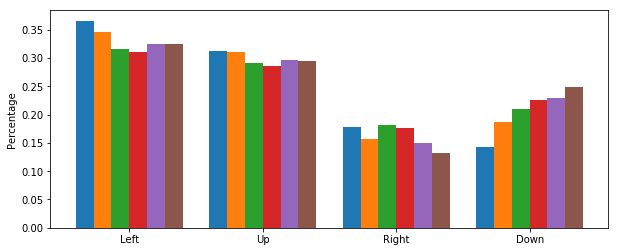

In [17]:
plt.figure(figsize=(10, 4))
plt.hist(moves, np.arange(5)-0.5, density=True)
plt.xticks(np.arange(4), ['Left', 'Up', 'Right', 'Down'])
# plt.legend([str(i) for i in range(0, len(indices), 10)])
plt.ylabel('Percentage')
plt.show()

Ratio of down moves is increasing.

In [18]:
import pandas as pd
import seaborn as sns

In [22]:
def group(index):
    if i < 100: return 'Fixed'
    if i < 200: return '100'
    if i < 300: return '200'
    if i < 400: return '300'
    if i < 500: return '400'
    if i < 600: return '500'
    if i < 700: return '600'

moves = pd.DataFrame(columns=['group','Left','Up','Right','Down'])
for i in indices:
    x = np.load('min'+str(i).zfill(5)+'.npz')
    hist = np.histogram(x['moves'], bins=np.arange(5))[0]
    hist = hist / hist.sum()
    moves = moves.append({'group': group(i),
                          'Left': hist[0],
                          'Up': hist[1],
                          'Right': hist[2],
                          'Down': hist[3]},
                          ignore_index=True)

In [23]:
moves = pd.melt(moves, id_vars='group', var_name='move', value_name='percent')

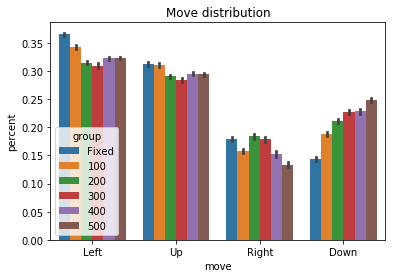

In [24]:
# Note: seaborn error bars are 95% CI of mean
ax = sns.barplot(x='move', y='percent', hue='group', data=moves)
ax.set_title('Move distribution')
plt.show()

Statistically higher down move preference. At some point, adding in the first 100 fixed games, the benefit of more training data (regularization) will no longer outweigh the out of distribution effect. This should happen around when networks trained on later games no longer generalize to the initial games.